In [8]:
from pylab import *
from numpy import *
%matplotlib inline
from matplotlib import gridspec

In [52]:
def rk4(ec,p_ini,x,args1=0,args2=0,h=0.01):
    if (x[1]-x[0]) <= 5.*h:
        h = (x[1]-x[0])/10
    tiempos = arange(x[0],x[1]+h,h)
    sol = zeros((len(tiempos),len(p_ini)))
    sol[0,:] = p_ini
    if args1==0:
        if args2==0:
            for i in range(len(tiempos)-1):
                k1 = ec(sol[i,:],tiempos[i])
                k2 = ec(sol[i,:]+0.5*h*k1,tiempos[i]+0.5*h)
                k3 = ec(sol[i,:]+0.5*h*k2,tiempos[i]+0.5*h)
                k4 = ec(sol[i,:]+h*k3,tiempos[i]+h)
                sol[i+1,:]=sol[i,:]+(h/6.)*(k1+2*k2+2*k3+k4)
        else:
            for i in range(len(tiempos)-1):
                k1 = ec(sol[i,:],tiempos[i])
                k2 = ec(sol[i,:]+0.5*h*k1,tiempos[i]+0.5*h,0,args2)
                k3 = ec(sol[i,:]+0.5*h*k2,tiempos[i]+0.5*h,0,args2)
                k4 = ec(sol[i,:]+h*k3,tiempos[i]+h,0,args2)
                sol[i+1,:]=sol[i,:]+(h/6.)*(k1+2*k2+2*k3+k4)
    else:
        if args2==0:
            for i in range(len(tiempos)-1):
                k1 = ec(sol[i,:],tiempos[i],args1)
                k2 = ec(sol[i,:]+0.5*h*k1,tiempos[i]+0.5*h,args1)
                k3 = ec(sol[i,:]+0.5*h*k2,tiempos[i]+0.5*h,args1)
                k4 = ec(sol[i,:]+h*k3,tiempos[i]+h,args1)
                sol[i+1,:]=sol[i,:]+(h/6.)*(k1+2*k2+2*k3+k4)
        else:
            for i in range(len(tiempos)-1):
                k1 = ec(sol[i,:],tiempos[i],args1,args2)
                k2 = ec(sol[i,:]+0.5*h*k1,tiempos[i]+0.5*h,args1,args2)
                k3 = ec(sol[i,:]+0.5*h*k2,tiempos[i]+0.5*h,args1,args2)
                k4 = ec(sol[i,:]+h*k3,tiempos[i]+h,args1,args2)
                sol[i+1,:]=sol[i,:]+(h/6.)*(k1+2*k2+2*k3+k4) 
    return tiempos,sol

In [60]:
def e_mov(r_v,t,fric=0,a=0,g=9.8,m=1): #r_v contiene a las coordenadas x y y y a las velocidades, a es el ángulo de inclinación del plano
    u = sqrt(r_v[2]**2 + r_v[3]**2)
    dx = r_v[2]
    dy = r_v[3]
    if fric == 0:
        if a==0:
            dvx,dvy = 0,-(g/m)
        else:
            dvx,dvy = (g/m)*sin(a),-(g/m)*cos(a)
    else:
        if a==0:
            dvx = - fric([r_v[2],r_v[3]])[0]
            dvy = -(g/m) - fric([r_v[2],r_v[3]])[1]
        else:
            dvx = - fric([r_v[2]*cos(a)+r_v[3]*sin(a),-r_v[2]*sin(a)+r_v[3]*cos(a)])[0]
            dvy = -(g/m) - fric([r_v[2]*cos(a)+r_v[3]*sin(a),-r_v[2]*sin(a)+r_v[3]*cos(a)])[1]
    return array([dx,dy,dvx,dvy])

In [142]:
def rebote(r_v_i,mi_dt):
    dt_busqueda = mi_dt/2.
    y_izq = r_v_i
    t,sol = rk4(e_mov,r_v_i,[0,dt_busqueda],fric_v)
    y_med = sol[-1,:]
    while abs(y_izq[1]) > 1e-5:
        if y_izq[1]*y_med[1] < 0:
            reinicio = y_izq
        else:
            reinicio = y_med
        dt_busqueda = dt_busqueda/2
        t,sol = rk4(e_mov,reinicio,[0,dt_busqueda],fric_v)
        y_izq = reinicio
        y_med = sol[-1,:]
    y_izq = array([y_izq[0],y_izq[1],y_izq[2],-y_izq[3]])    
    return y_izq

In [138]:
def fric_v(v,gamma=0.1):
    f_x = gamma*v[0]
    f_y = gamma*v[1]
    return array([f_x,f_y]) 

def fric_v2(v,gamma=0.1):
    norm_v = sqrt(v[0]**2 + v[1]**2)
    f_x = gamma*norm_v*v[0]
    f_y = gamma*norm_v*v[1]
    return array([f_x,f_y]) 

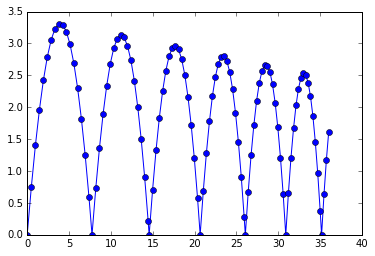

In [163]:
inicio = [0,0,5,8]
a= pi/3
N = 100
trayectoria = zeros((N,len(inicio)))
mi_dt = .1
trayectoria[0,:] = array(inicio)
for i in range(N-1):
    t,sol_dt = rk4(e_mov,trayectoria[i,:],[0,mi_dt],fric_v,a,h=0.01)
    if sol_dt[-1,:][1] < 0:
        punto = rebote(trayectoria[i,:],mi_dt)
        trayectoria[i+1,:] = punto
    else:
        trayectoria[i+1,:] = sol_dt[-1,:]

plot(trayectoria[:,0],trayectoria[:,1],'o-')
show()



Tenemos ya la solución en el marco rotado; ahora sólo debemos de rotarla al marco original para poder graficarla. Esto se hace haciendo el inverso de la transformación de antes:
$$
x_0= xcos \alpha -ysen \alpha
$$
$$
y_0= ycos \alpha +xsen \alpha
$$

In [164]:
trayectoriarot= trayectoria
for i in range(len(trayectoria[:,0])):
    trayectoria[:,0] = trayectoriarot[:,0]*cos(a)-trayectoriarot[:,1]*sin(a)
    trayectoria[:,1] = trayectoriarot[:,1]*cos(a)+trayectoriarot[:,0]*sin(a)
    trayectoria[:,2] = trayectoriarot[:,2]*cos(a)-trayectoriarot[:,3]*sin(a)
    trayectoria[:,3] = trayectoriarot[:,3]*cos(a)+trayectoriarot[:,2]*sin(a)


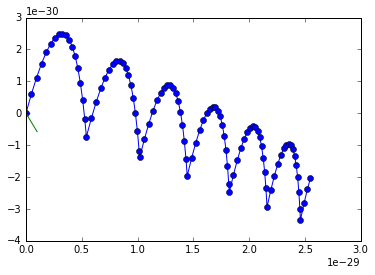

In [169]:
x =linspace(0,1e-30)
plot(trayectoria[:,0],trayectoria[:,1],'o-')
plot(x,-x/sqrt(3))
show()